In [ ]:
import os 
os.chdir('/content/drive/My Drive/kaggle_study/dacon_jejucard')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


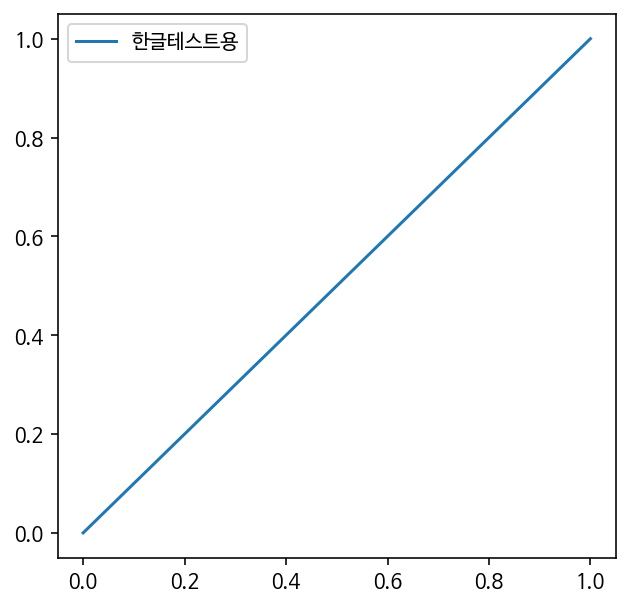

In [ ]:
# 한글 폰트 테스트
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

# 데이터 준비

In [ ]:
st = time.time()
data = pd.read_csv('201901-202003.csv')
print(data.shape)
print(time.time() - st)
data.head()

(24697792, 12)
49.71646738052368


,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [ ]:
# 날짜 년,월 col 추가
years = pd.to_datetime(data['REG_YYMM'],format='%Y%m',).dt.year
months = pd.to_datetime(data['REG_YYMM'],format='%Y%m').dt.month
data['year'] = years
data['month'] = months

# 전년 대비 증감율

- 2020년 데이터가 3월 까지 있으므로 2019년 3월까지의 데이터와 비교하여 증감율 계산

In [ ]:

diff01 =data[(data['REG_YYMM']==201901) | (data['REG_YYMM']==202001)]
diff02 =data[(data['REG_YYMM']==201902) | (data['REG_YYMM']==202002)]
diff03 =data[(data['REG_YYMM']==201903) | (data['REG_YYMM']==202003)]


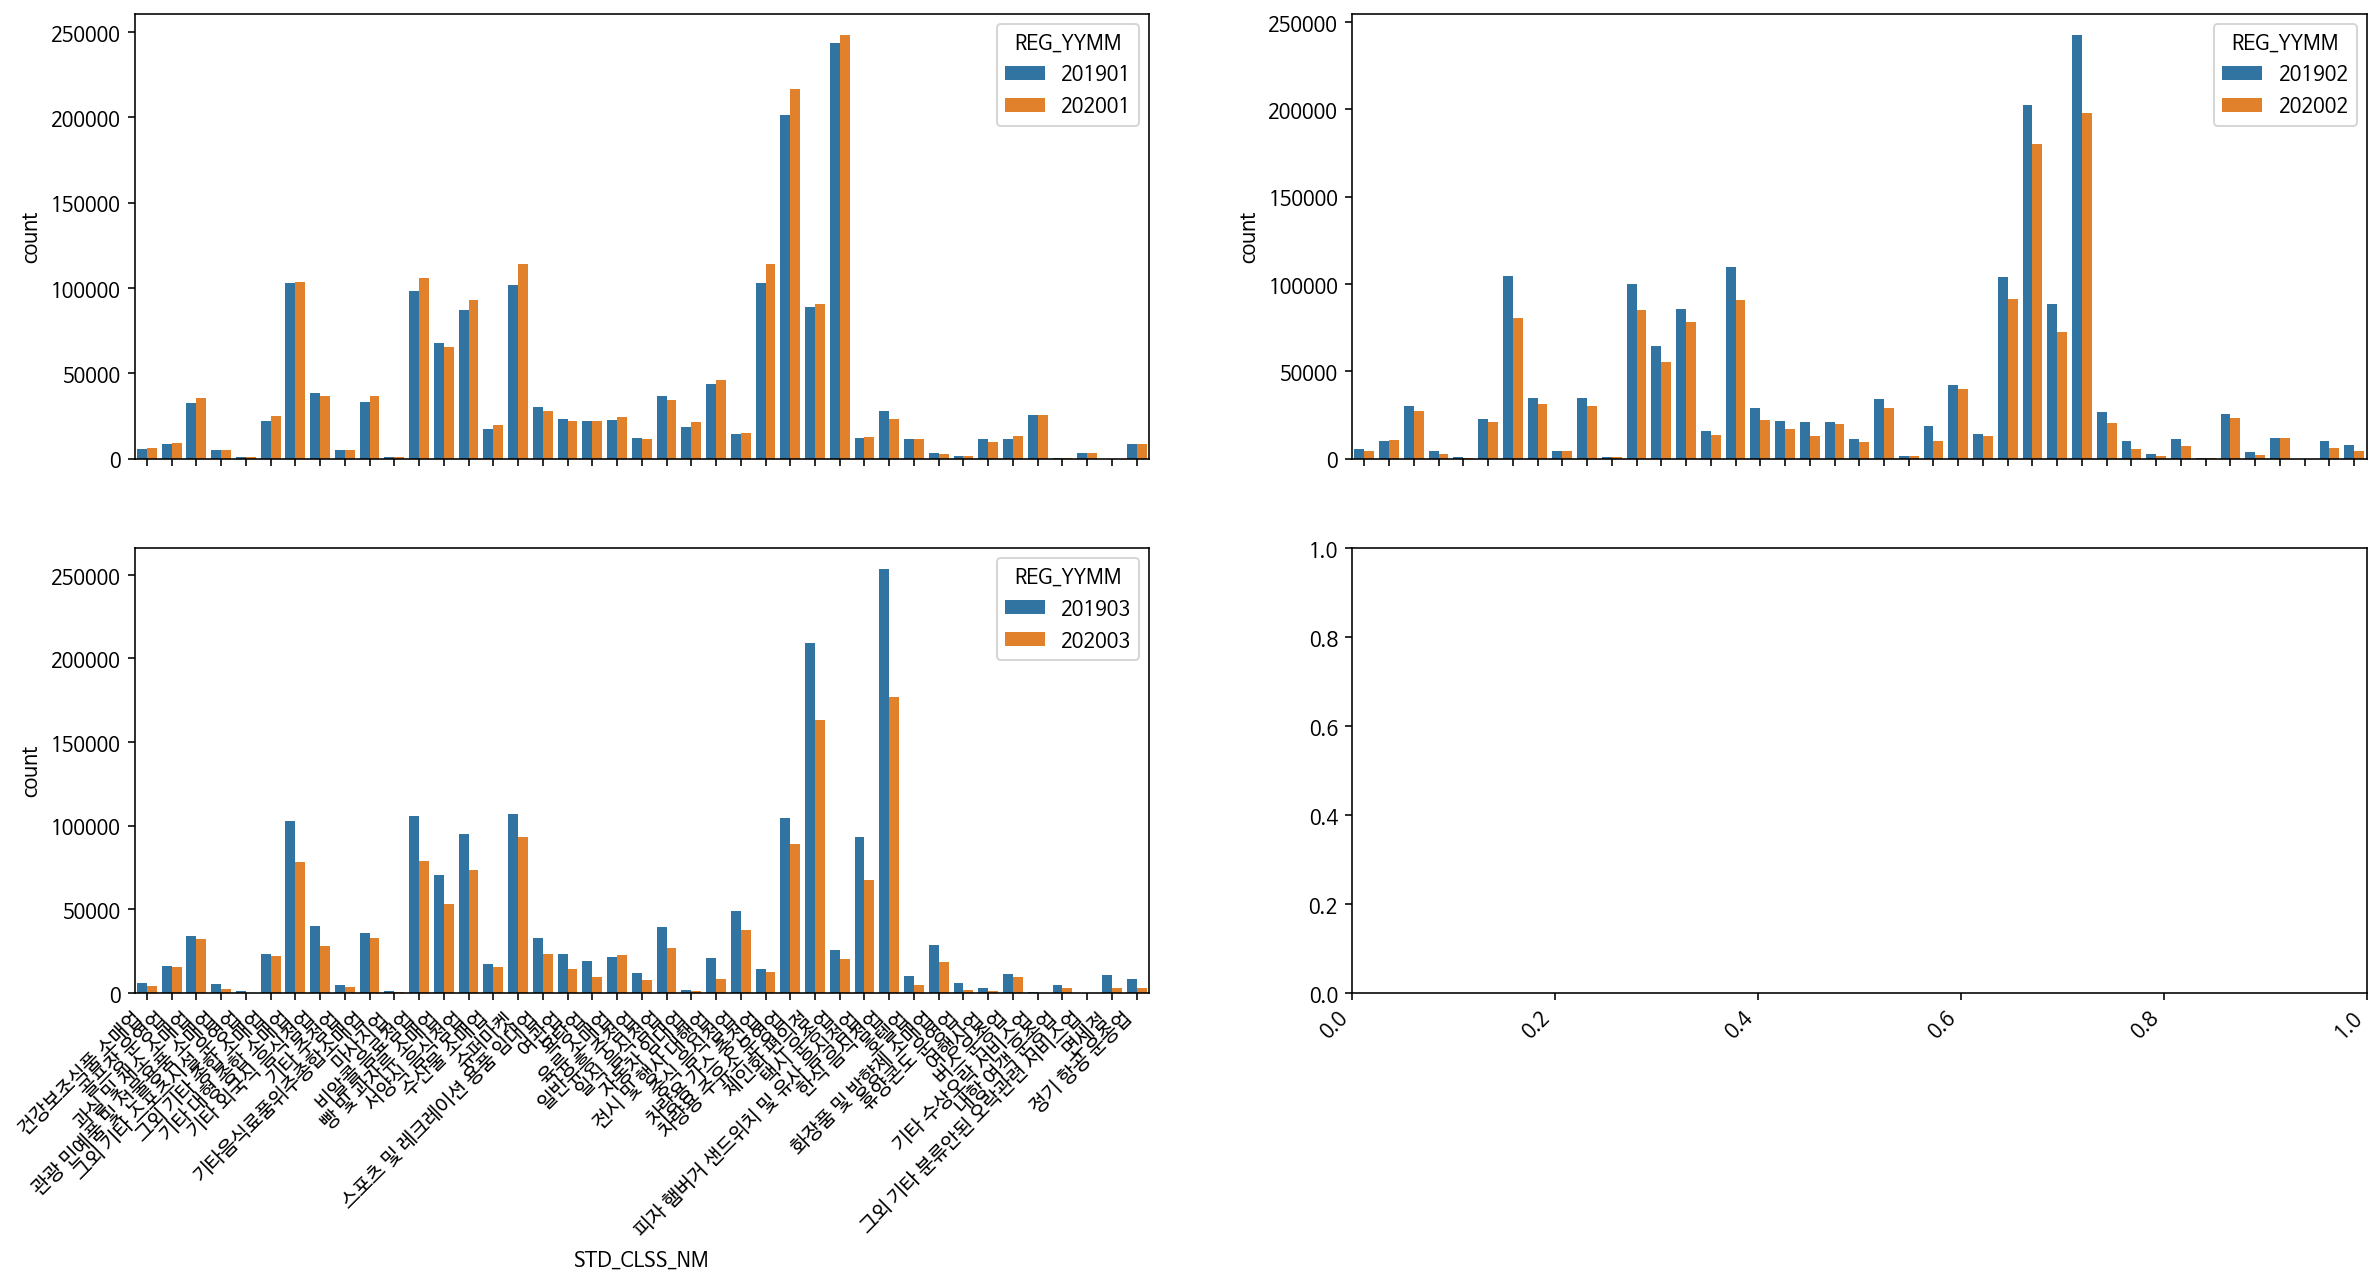

In [ ]:
fig2,ax = plt.subplots(2,2)
fig2.set_size_inches(20,10)


sns.countplot(diff01['STD_CLSS_NM'],hue=diff01['REG_YYMM'],ax=ax[0,0])
sns.countplot(diff02['STD_CLSS_NM'],hue=diff02['REG_YYMM'],ax=ax[0,1])
sns.countplot(diff03['STD_CLSS_NM'],hue=diff03['REG_YYMM'],ax=ax[1,0])

fig2.autofmt_xdate(rotation=45)

- 20년 1월까진 19년과 차이가 크게 없다
- 20년 2월부터 각 업종들이 코로나의 영향을 받는다


- 3월이 코로나의 영향으로 인한 매출 변화를 잘 반영해준다고 판단된다. 과적합이 발생할 수도 있으니 3월의 전년대비 증감율을 코로나 영향에 의한 변동률이라 대변하고 2020년 2,3월의 데이터에 증감율을 적용.

## 업종별 증감율

In [ ]:
diff03_count= diff03.groupby(['STD_CLSS_NM','REG_YYMM'])['AMT'].sum()
diff03_count= diff03_count.reset_index(name='count')

In [ ]:
diff03_count

,STD_CLSS_NM,REG_YYMM,count
0,건강보조식품 소매업,201903,6307887107
1,건강보조식품 소매업,202003,5753676884
2,골프장 운영업,201903,42108966385
3,골프장 운영업,202003,39398851940
4,과실 및 채소 소매업,201903,38415185909
...,...,...,...
77,호텔업,202003,5073633041
78,화장품 및 방향제 소매업,201903,48695291945
79,화장품 및 방향제 소매업,202003,31002789304
80,휴양콘도 운영업,201903,3378598195


In [ ]:
diff03_count[diff03_count['STD_CLSS_NM']=='호텔업']

,STD_CLSS_NM,REG_YYMM,count
76,호텔업,201903,13817431974
77,호텔업,202003,5073633041


In [ ]:
dicts ={}
for i in diff03_count['STD_CLSS_NM'].unique():
    last_year = diff03_count.loc[(diff03_count['STD_CLSS_NM']==i)&(diff03_count['REG_YYMM']==201903)]['count'].values
    this_year = diff03_count.loc[(diff03_count['STD_CLSS_NM']==i)&(diff03_count['REG_YYMM']==202003)]['count'].values
    rate = ((this_year - last_year) / last_year)
    dicts[i] = round(float(rate),2)

In [ ]:
dicts

{'건강보조식품 소매업': -0.09,
 '골프장 운영업': -0.06,
 '과실 및 채소 소매업': 0.11,
 '관광 민예품 및 선물용품 소매업': -0.54,
 '그외 기타 분류안된 오락관련 서비스업': -0.21,
 '그외 기타 스포츠시설 운영업': -0.82,
 '그외 기타 종합 소매업': 0.14,
 '기타 대형 종합 소매업': -0.19,
 '기타 수상오락 서비스업': -0.37,
 '기타 외국식 음식점업': -0.35,
 '기타 주점업': -0.32,
 '기타음식료품위주종합소매업': 0.2,
 '내항 여객 운송업': -0.56,
 '마사지업': -0.48,
 '면세점': -0.87,
 '버스 운송업': -0.7,
 '비알콜 음료점업': -0.2,
 '빵 및 과자류 소매업': -0.11,
 '서양식 음식점업': -0.27,
 '수산물 소매업': 0.06,
 '슈퍼마켓': 0.2,
 '스포츠 및 레크레이션 용품 임대업': -0.4,
 '여관업': -0.39,
 '여행사업': -0.95,
 '욕탕업': -0.54,
 '육류 소매업': 0.34,
 '일반유흥 주점업': -0.4,
 '일식 음식점업': -0.36,
 '자동차 임대업': 0.38,
 '전시 및 행사 대행업': -0.74,
 '정기 항공 운송업': -0.93,
 '중식 음식점업': -0.26,
 '차량용 가스 충전업': -0.1,
 '차량용 주유소 운영업': -0.09,
 '체인화 편의점': -0.02,
 '택시 운송업': -0.25,
 '피자 햄버거 샌드위치 및 유사 음식점업': -0.13,
 '한식 음식점업': -0.32,
 '호텔업': -0.63,
 '화장품 및 방향제 소매업': -0.36,
 '휴양콘도 운영업': -0.68}

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


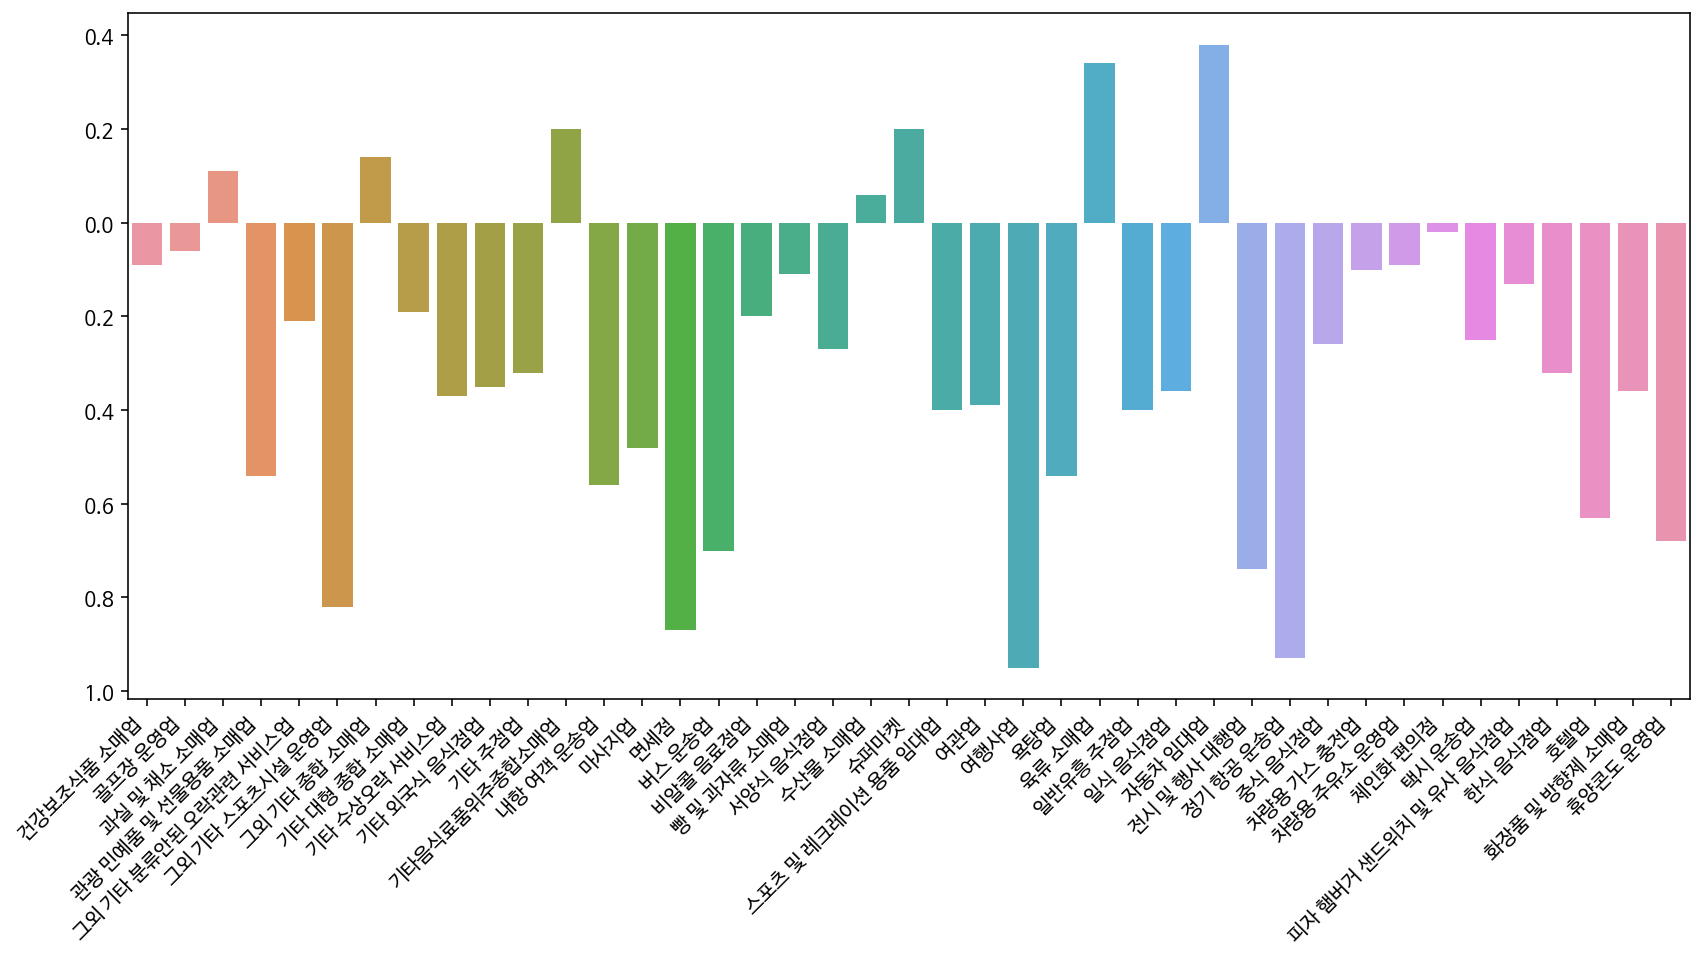

In [ ]:
fig = plt.figure(figsize=(14,7))
sns.barplot(list(dicts.keys()),list(dicts.values()))
fig.autofmt_xdate(rotation=45)

- 감소율이 가장 큰 건 여행사업과 정기 항공 운송업이다. 그 뒤로 면세점과 스포츠시설 운영업 등이 뒤따른다.

- 소매, 식료품, 자동차 임대업 등은 증가했다.

In [ ]:
diff03

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
3201298,201903,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,5,4199000,5,2019,3
3201299,201903,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,4,324000,4,2019,3
3201300,201903,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,439000,3,2019,3
3201301,201903,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,2,3,4,1086400,3,2019,3
3201302,201903,강원,강릉시,건강보조식품 소매업,강원,강릉시,50s,1,4,11,1157400,12,2019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,202003,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4,2020,3
24697788,202003,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3,2020,3
24697789,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6,2020,3
24697790,202003,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6,2020,3


## 시도 및 업종 증감율 

In [ ]:
sido_diff03 = diff03.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum()

In [ ]:
sido_diff03 = sido_diff03.reset_index(name='count')

In [ ]:
sido_diff03.loc[(sido_diff03['CARD_SIDO_NM']=='제주')&(sido_diff03['STD_CLSS_NM']=='택시 운송업')]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,count
1162,202003,제주,택시 운송업,471100


In [ ]:

card_sido_nms =sido_diff03['CARD_SIDO_NM'].unique()
STD_CLSS_NMS = sido_diff03['STD_CLSS_NM'].unique()

dicts = {}

for sido in card_sido_nms:
    d ={}
    for clss in sido_diff03.loc[sido_diff03['CARD_SIDO_NM']==sido,'STD_CLSS_NM'].unique():
        last_year = sido_diff03.loc[(sido_diff03['REG_YYMM']==201903) & (sido_diff03['CARD_SIDO_NM']==sido) & (sido_diff03['STD_CLSS_NM']==clss)]['count'].values
        this_year = sido_diff03.loc[(sido_diff03['REG_YYMM']==202003) & (sido_diff03['CARD_SIDO_NM']==sido) & (sido_diff03['STD_CLSS_NM']==clss)]['count'].values
        if (last_year.size==0) :
            last_year= 1
        if this_year.size==0 :
            this_year= 1
        

        rate = (this_year-last_year)/last_year
        d[clss] = round(float(rate),2)
    dicts[sido] = d
    

In [ ]:
dicts['제주']

In [ ]:
sido_diff03[(sido_diff03['CARD_SIDO_NM']=='제주') & (sido_diff03['STD_CLSS_NM']=='면세점')]

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,count
529,201903,제주,면세점,7585380787
1142,202003,제주,면세점,2590699901


In [ ]:
tmp = sido_diff03.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])['count'].sum()
tmp = tmp.reset_index(name='count')

In [ ]:
lists = []
for sido in tmp['CARD_SIDO_NM'].unique():
    for clss in tmp.loc[tmp['CARD_SIDO_NM']==sido]['STD_CLSS_NM'].unique():
        # print(sido,clss)
        val = dicts[sido][clss]
        lists.append(val)

In [ ]:
len(lists)

634

In [ ]:
tmp['yoy'] =lists

In [ ]:
tmp[(tmp['yoy']>=10)]

,CARD_SIDO_NM,STD_CLSS_NM,count,yoy
51,경기,버스 운송업,2413578420,68.47
521,제주,그외 기타 분류안된 오락관련 서비스업,313500,313499.00
525,제주,기타 수상오락 서비스업,1606700,1606699.00
551,제주,택시 운송업,471100,471099.00
571,충남,버스 운송업,322074,322073.00


In [ ]:
tmp[(tmp['CARD_SIDO_NM']=='제주') & (tmp['yoy']>=10)]

,CARD_SIDO_NM,STD_CLSS_NM,count,yoy
554,제주,호텔업,1623667732,313499.0
555,제주,화장품 및 방향제 소매업,1083163148,1606699.0
556,제주,휴양콘도 운영업,600033770,471099.0


In [ ]:
tmp.shape

(634, 4)

In [ ]:
tmp.to_csv('yoy_by_sido_clss.csv',index=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


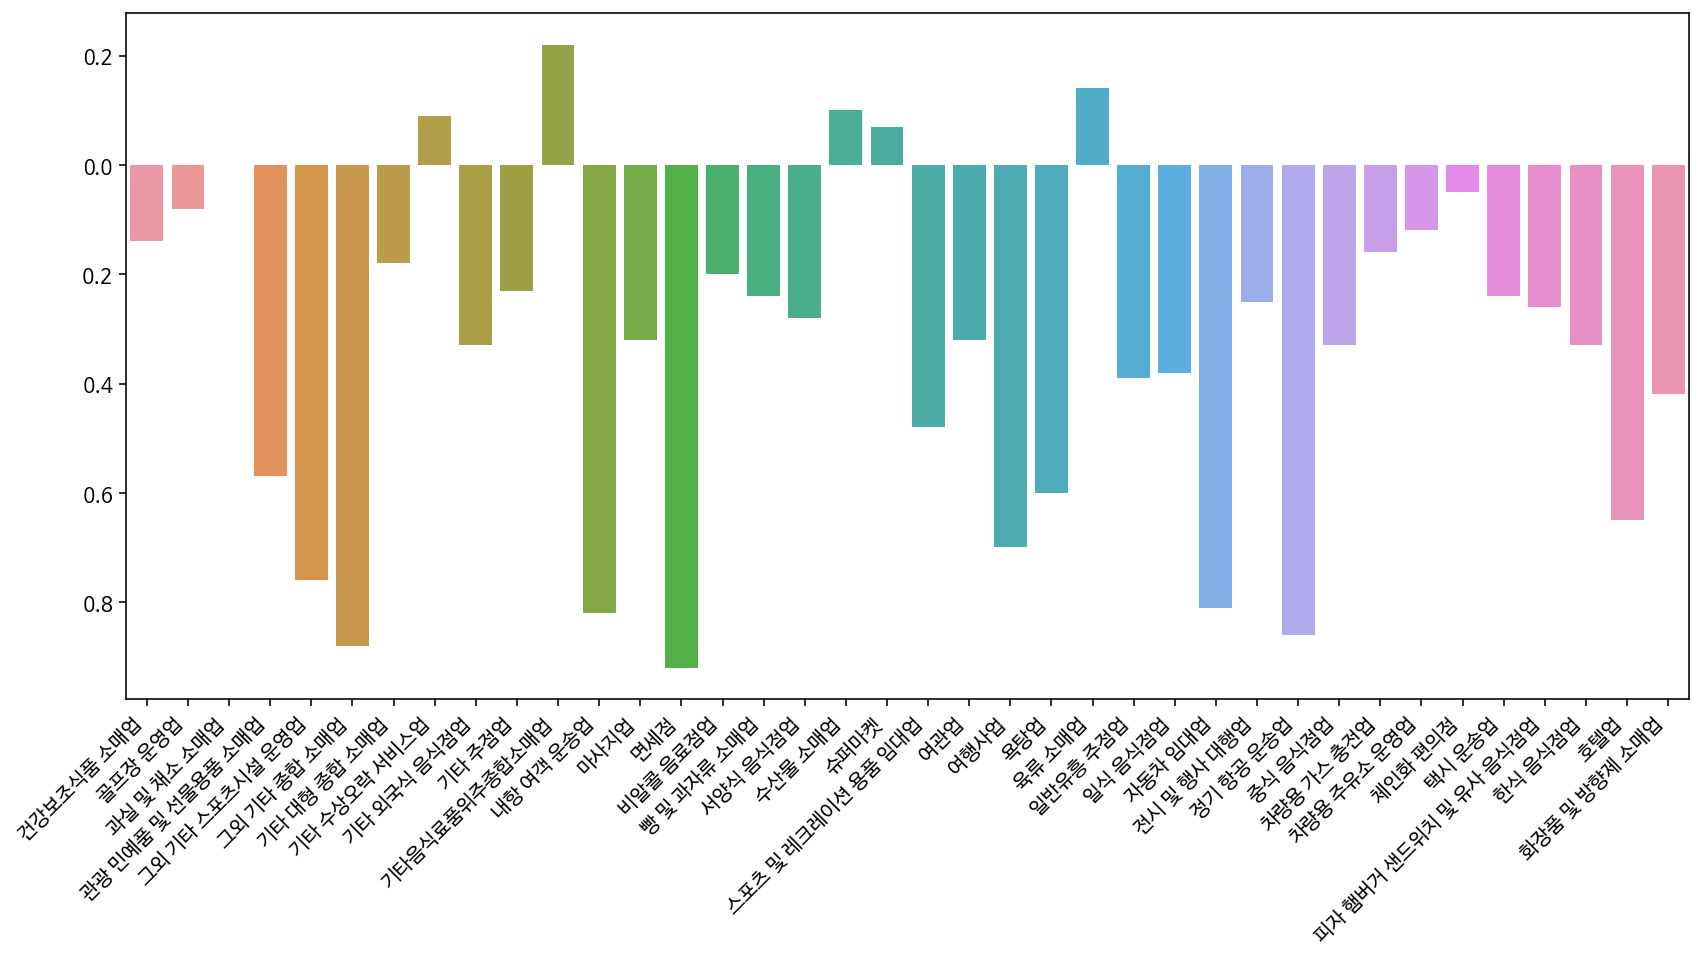

In [ ]:
fig = plt.figure(figsize=(14,7))
sns.barplot(list(dicts['인천'].keys()),list(dicts['인천'].values()))
fig.autofmt_xdate(rotation=45)

-전년대비 증감율(YoY) 을 통해 지역별로 증가한 업종과 감소폭이 큰 업종 등을 볼 수 있다.

# 전년AMTx전년대비변동율

-2019년 AMT에 2020년 YoY를 곱한 값과 실제 2020년 AMT를 비교하기 위함. YoY가 얼마나 유용한지를 볼 수 있음.

In [ ]:
data04 = data[data['REG_YYMM']==201904].groupby(['CARD_SIDO_NM','STD_CLSS_NM'])['AMT'].sum()
data04= data04.reset_index(name='AMT')

In [ ]:
data04

,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,강원,건강보조식품 소매업,106548473
1,강원,골프장 운영업,3964893280
2,강원,과실 및 채소 소매업,827683360
3,강원,관광 민예품 및 선물용품 소매업,17905610
4,강원,그외 기타 스포츠시설 운영업,5904100
...,...,...,...
628,충북,피자 햄버거 샌드위치 및 유사 음식점업,1428268910
629,충북,한식 음식점업,22162873793
630,충북,호텔업,40510930
631,충북,화장품 및 방향제 소매업,687254347


In [ ]:
yoy_sum= yoy_sum[yoy_sum['REG_YYMM']==201904]

In [ ]:
yoy_sum.shape

(627, 5)

In [ ]:
a= pd.merge(data04,yoy_sum,left_on=['CARD_SIDO_NM', 'STD_CLSS_NM'],right_on=['CARD_SIDO_NM', 'STD_CLSS_NM'],how='left')

In [ ]:
a.loc[a['yoy2'].isnull(),'yoy2']=0

In [ ]:
a['yoy&amt'] = a['AMT_x'] * a['yoy2'] 

In [ ]:
# sub는 2020년 4월의 정답 값
sub[sub['REG_YYMM']==202004]

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,8.882399e+07
1,1,202004,강원,골프장 운영업,4.708347e+09
2,2,202004,강원,과실 및 채소 소매업,1.121029e+09
3,3,202004,강원,관광 민예품 및 선물용품 소매업,1.436078e+07
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
...,...,...,...,...,...
692,692,202004,충북,피자 햄버거 샌드위치 및 유사 음식점업,1.373636e+09
693,693,202004,충북,한식 음식점업,1.891104e+10
694,694,202004,충북,호텔업,1.412150e+07
695,695,202004,충북,화장품 및 방향제 소매업,4.505074e+08


In [ ]:
diff = pd.merge(sub[sub['REG_YYMM']==202004],a,left_on=['CARD_SIDO_NM', 'STD_CLSS_NM'],right_on=['CARD_SIDO_NM', 'STD_CLSS_NM'],how='left')

In [ ]:
diff.loc[diff['AMT_x'].isnull(),'AMT_x'] = 0

In [ ]:
diff

,id,REG_YYMM_x,CARD_SIDO_NM,STD_CLSS_NM,AMT,AMT_x,REG_YYMM_y,yoy2,AMT_y,yoy&amt
0,0,202004,강원,건강보조식품 소매업,8.882399e+07,1.065485e+08,201904.0,0.88,1599000.0,9.376266e+07
1,1,202004,강원,골프장 운영업,4.708347e+09,3.964893e+09,201904.0,1.06,15107400.0,4.202787e+09
2,2,202004,강원,과실 및 채소 소매업,1.121029e+09,8.276834e+08,201904.0,1.06,7321750.0,8.773444e+08
3,3,202004,강원,관광 민예품 및 선물용품 소매업,1.436078e+07,1.790561e+07,201904.0,0.53,1615620.0,9.489973e+06
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
692,692,202004,충북,피자 햄버거 샌드위치 및 유사 음식점업,1.373636e+09,1.428269e+09,201904.0,0.91,2713440.0,1.299725e+09
693,693,202004,충북,한식 음식점업,1.891104e+10,2.216287e+10,201904.0,0.70,1694600.0,1.551401e+10
694,694,202004,충북,호텔업,1.412150e+07,4.051093e+07,201904.0,0.42,5220900.0,1.701459e+07
695,695,202004,충북,화장품 및 방향제 소매업,4.505074e+08,6.872543e+08,201904.0,0.59,3406860.0,4.054801e+08


In [ ]:
from sklearn.metrics import mean_squared_log_error
import numpy as np
np.sqrt(mean_squared_log_error(diff['AMT'],diff['yoy&amt']))

2.0741202567782624

2019년 AMT에 YoY를 곱한 값과 정답 값의 RMSLE는 2.07 정도이다. YoY가 유용할 것으로 판단됨.